In [1]:
from tensorflow.keras.models import load_model
from PIL import ImageFile, Image
import cv2
import numpy as np
import base64
import keras
import matplotlib.pyplot as plt

im = Image.open('/home/ai_car/Preprocessing-MedicalImage/image/00003308_001.png')

def estimate_blur(image: np.array, threshold: int = 100):
    """
    It calculates the variance of the Laplacian of the image
    
    :param image: The image that you want to check for blur
    :type image: np.array
    :param threshold: The minimum variance of the Laplacian to qualify a region as blurry, defaults to
    100
    :type threshold: int (optional)
    :return: The variance of the Laplacian of the image.
    """
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blur_map = cv2.Laplacian(image, cv2.CV_64F)
    score = np.var(blur_map)
    return score, bool(score < threshold)
    
def toBase64HardScores(imageArray):
    """
    It takes an image array, converts it to a jpg, converts the jpg to bytes, converts the bytes to
    base64, and then converts the base64 to a string.
    
    :param imageArray: The image array that you want to convert to base64
    :return: A base64 encoded string of the image
    """
    _, buffer = cv2.imencode('.jpg', imageArray)
    im_bytes = buffer.tobytes()
    jpg_as_text = base64.b64encode(im_bytes)
    imgArray = jpg_as_text.decode('utf8')
    return imgArray


def CheckBlurImage(ImageArray, type = "web"):
    score, blurry = estimate_blur(ImageArray, 100)
    base64toOutputs = toBase64HardScores(imageArray= ImageArray)
    if type == 'web':
        data = {
            'Score' : score,
            'scoreBlur' : blurry,
            'Base64Image' : base64toOutputs
        }   
        return data
    if type == 'app':
        return blurry

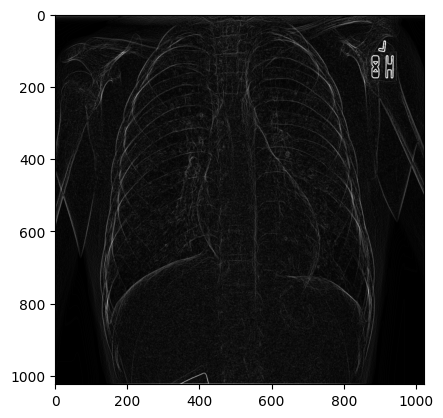

In [2]:
def sobelOperator(img):
    container = np.copy(img)
    size = container.shape
    for i in range(1, size[0] - 1):
        for j in range(1, size[1] - 1):
            gx = (img[i - 1][j - 1] + 2*img[i][j - 1] + img[i + 1][j - 1]) - (img[i - 1][j + 1] + 2*img[i][j + 1] + img[i + 1][j + 1])
            gy = (img[i - 1][j - 1] + 2*img[i - 1][j] + img[i - 1][j + 1]) - (img[i + 1][j - 1] + 2*img[i + 1][j] + img[i + 1][j + 1])
            container[i][j] = min(255, np.sqrt(gx**2 + gy**2))
    return container

img = cv2.cvtColor(cv2.imread("/home/ai_car/Preprocessing-MedicalImage/image/00003308_001.png"), cv2.COLOR_BGR2GRAY)
img = sobelOperator(img)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
plt.imshow(img)

In [3]:
from scipy import ndimage

xray_image_laplace_gaussian = ndimage.gaussian_laplace(im, sigma=1)
x_ray_image_gaussian_gradient = ndimage.gaussian_gradient_magnitude(im, sigma=2)
x_sobel = ndimage.sobel(im, axis=0)
y_sobel = ndimage.sobel(im, axis=1)

xray_image_sobel = np.hypot(x_sobel, y_sobel)

xray_image_sobel *= 255.0 / np.max(xray_image_sobel)
print("The data type - before: ", xray_image_sobel.dtype)

xray_image_sobel = xray_image_sobel.astype("float32")

print("The data type - after: ", xray_image_sobel.dtype)

fourier_gaussian = ndimage.fourier_gaussian(im, sigma=0.05)

x_prewitt = ndimage.prewitt(fourier_gaussian, axis=0)
y_prewitt = ndimage.prewitt(fourier_gaussian, axis=1)

xray_image_canny = np.hypot(x_prewitt, y_prewitt)

xray_image_canny *= 255.0 / np.max(xray_image_canny)

print("The data type - ", xray_image_canny.dtype)

The data type - before:  float16
The data type - after:  float32
The data type -  float64


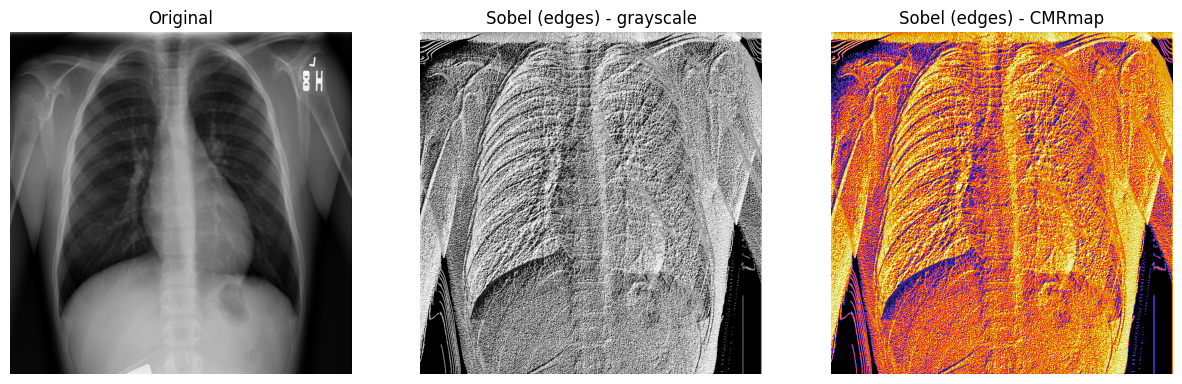

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))

axes[0].set_title("Original")
axes[0].imshow(im, cmap="gray")
axes[1].set_title("Sobel (edges) - grayscale")
axes[1].imshow(xray_image_sobel, cmap="gray")
axes[2].set_title("Sobel (edges) - CMRmap")
axes[2].imshow(xray_image_sobel, cmap="CMRmap")
for i in axes:
    i.axis("off")
plt.show()

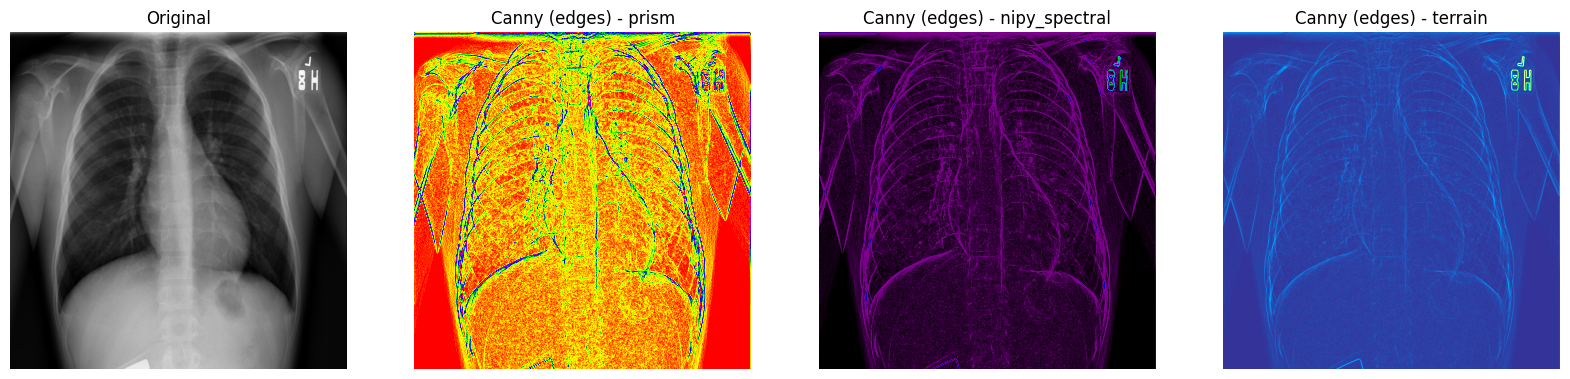

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 15))

axes[0].set_title("Original")
axes[0].imshow(im, cmap="gray")
axes[1].set_title("Canny (edges) - prism")
axes[1].imshow(xray_image_canny, cmap="prism")
axes[2].set_title("Canny (edges) - nipy_spectral")
axes[2].imshow(xray_image_canny, cmap="nipy_spectral")
axes[3].set_title("Canny (edges) - terrain")
axes[3].imshow(xray_image_canny, cmap="terrain")
for i in axes:
    i.axis("off")
plt.show()

In [6]:
# print("The data type of the X-ray image is: ", im.dtype)
print("The minimum pixel value is: ", np.min(im))
print("The maximum pixel value is: ", np.max(im))
print("The average pixel value is: ", np.mean(im))
print("The median pixel value is: ", np.median(im))

The minimum pixel value is:  0
The maximum pixel value is:  253
The average pixel value is:  84.31250858306885
The median pixel value is:  82.0


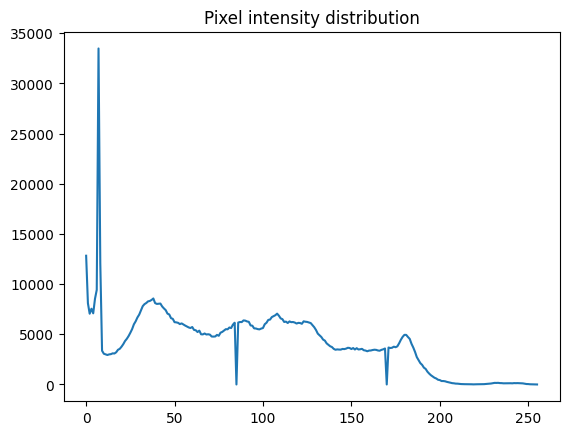

In [7]:
pixel_intensity_distribution = ndimage.histogram(
    im, min=np.min(im), max=np.max(im), bins=256
)

plt.plot(pixel_intensity_distribution)
plt.title("Pixel intensity distribution")
plt.show()

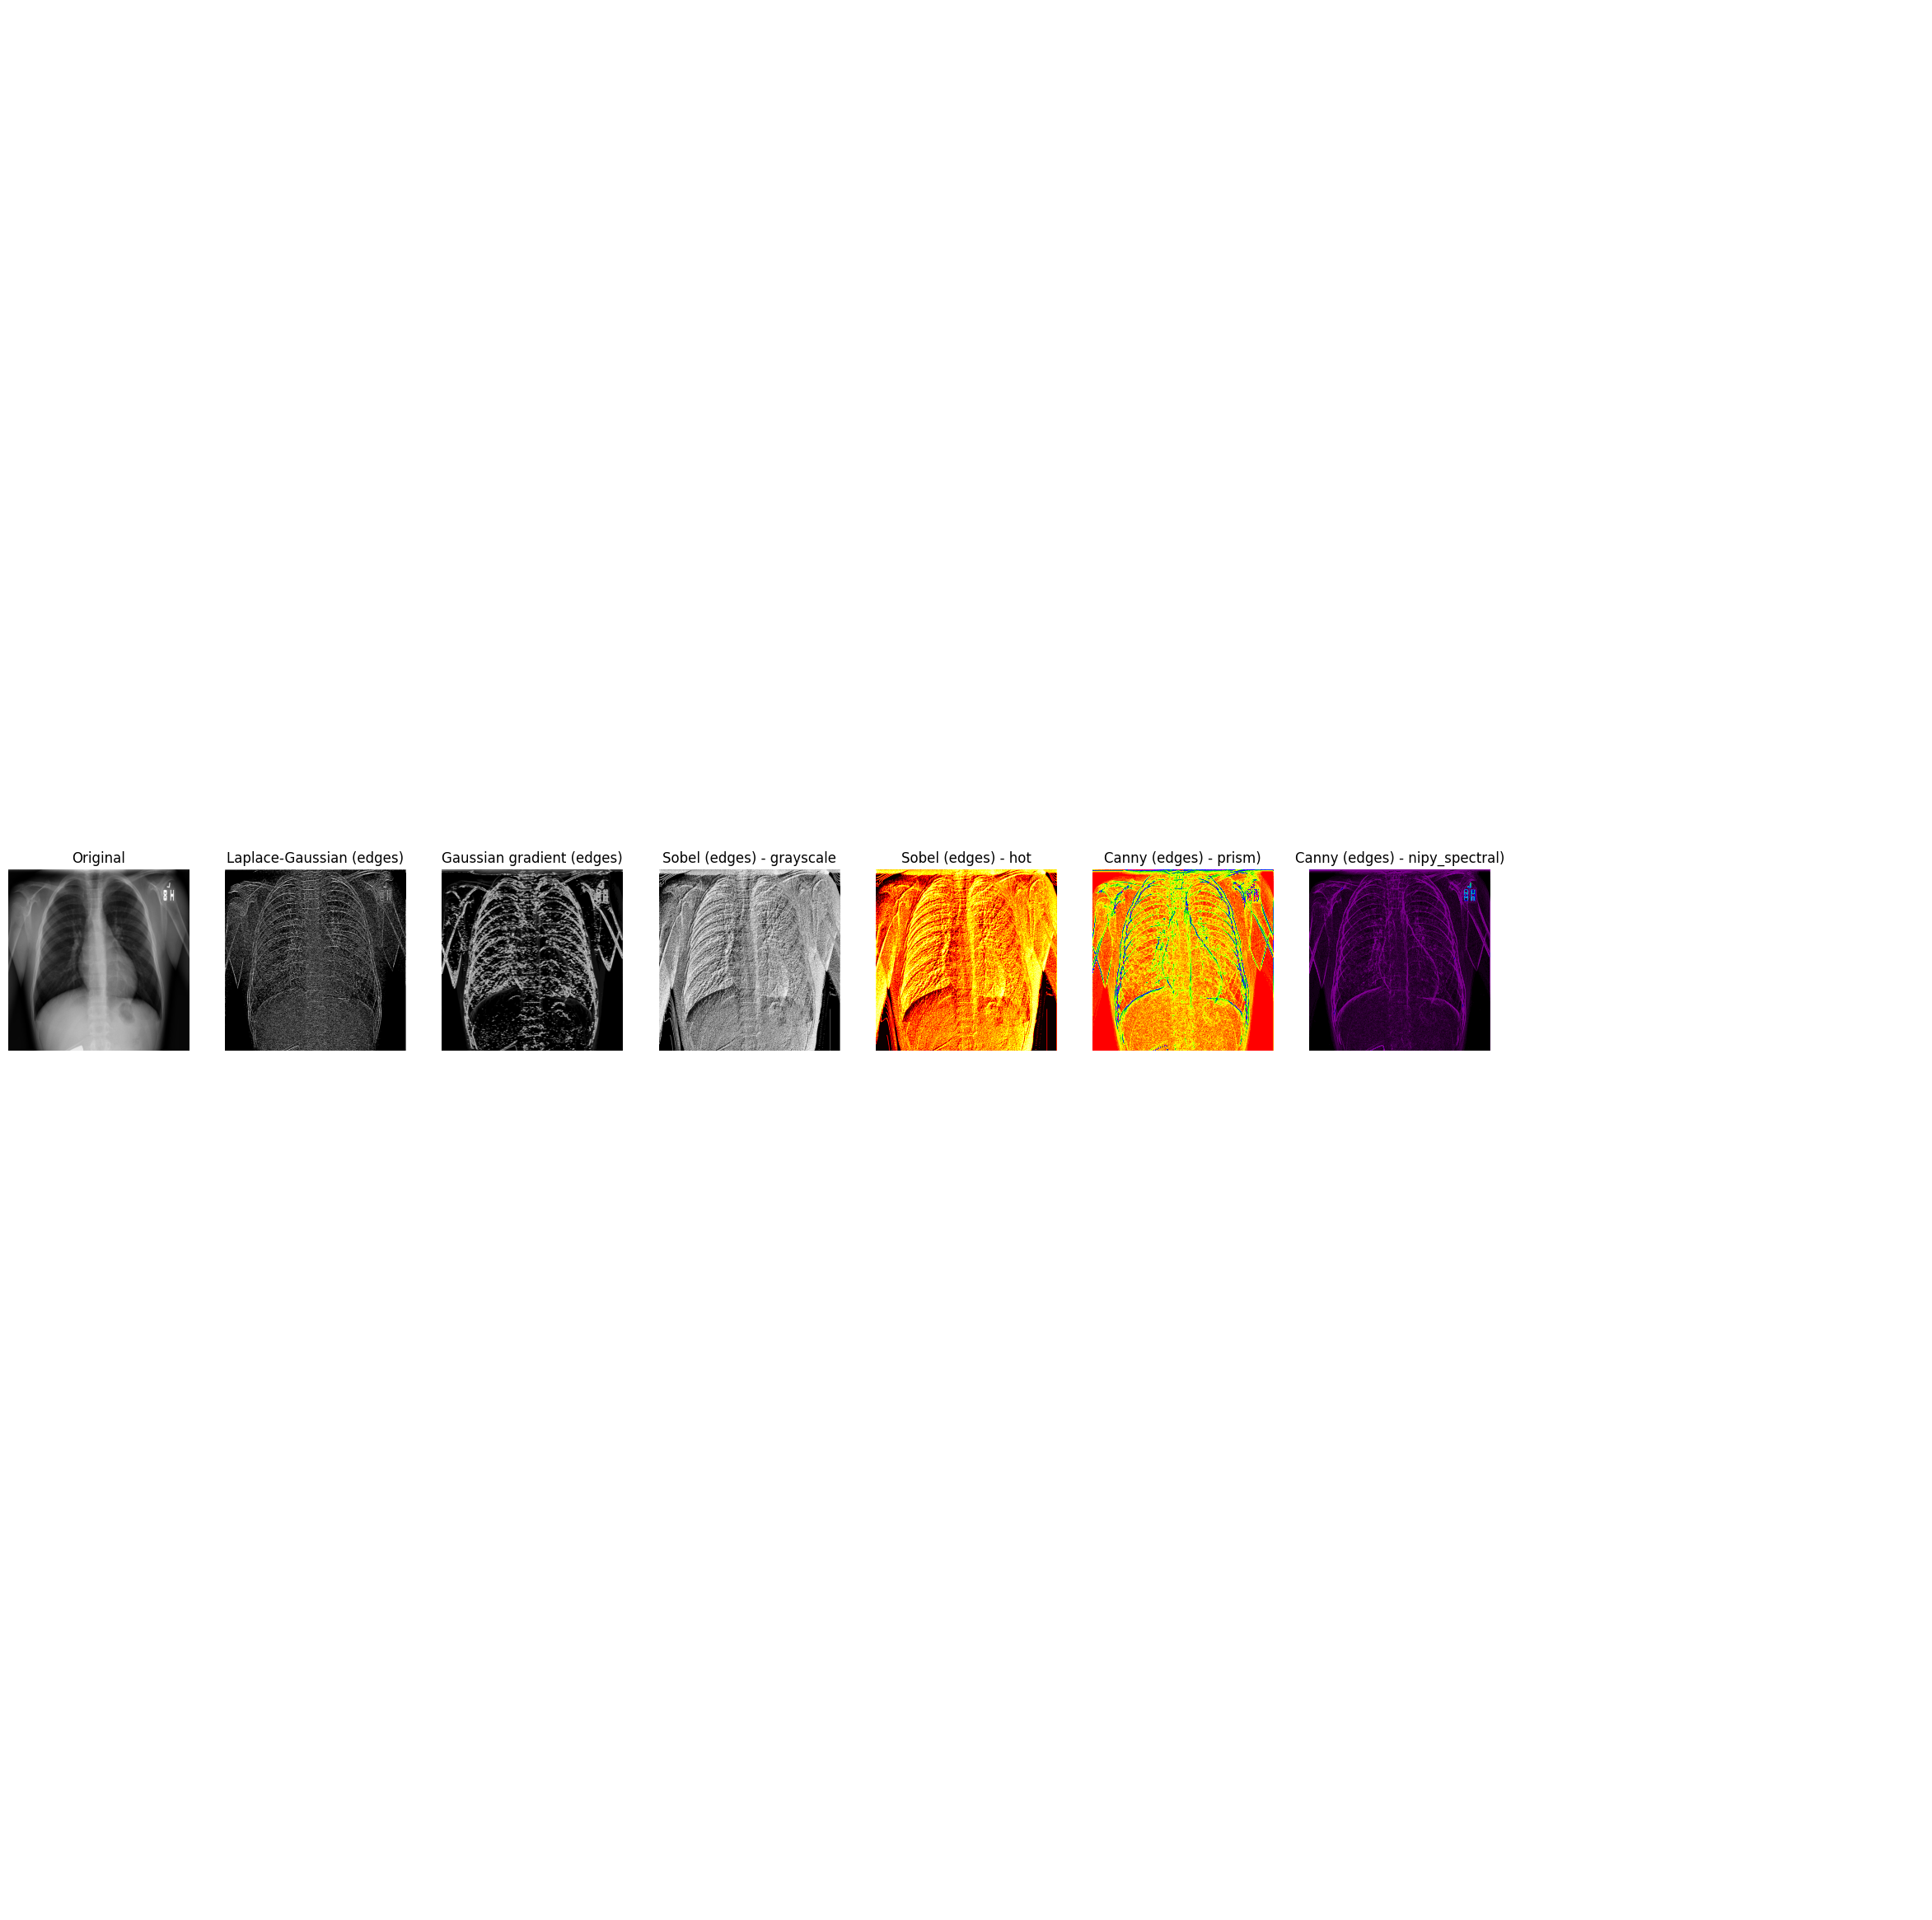

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(30, 30))

axes[0].set_title("Original")
axes[0].imshow(im, cmap="gray")
axes[1].set_title("Laplace-Gaussian (edges)")
axes[1].imshow(xray_image_laplace_gaussian, cmap="gray")
axes[2].set_title("Gaussian gradient (edges)")
axes[2].imshow(x_ray_image_gaussian_gradient, cmap="gray")
axes[3].set_title("Sobel (edges) - grayscale")
axes[3].imshow(xray_image_sobel, cmap="gray")
axes[4].set_title("Sobel (edges) - hot")
axes[4].imshow(xray_image_sobel, cmap="hot")
axes[5].set_title("Canny (edges) - prism)")
axes[5].imshow(xray_image_canny, cmap="prism")
axes[6].set_title("Canny (edges) - nipy_spectral)")
axes[6].imshow(xray_image_canny, cmap="nipy_spectral")
# axes[7].set_title("Mask (> 150, noisy)")
# axes[7].imshow(xray_image_mask_noisy, cmap="gray")
# axes[8].set_title("Mask (> 150, less noisy)")
# axes[8].imshow(xray_image_mask_less_noisy, cmap="gray")
for i in axes:
    i.axis("off")
plt.show()

In [23]:

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
    
modelSeg = load_model('/home/ai_car/Preprocessing-MedicalImage/model/u_net.h5', custom_objects={'dice_coef':dice_coef,
                                                                                            'dice_coef_loss': dice_coef_loss})

# image = Image.open('result/1.png') #.convert('L')
# image = image.resize((128, 128))
# image = np.asarray(image)
# image = image.reshape(image.shape[0], image.shape[1], 1)
# original = image.copy()
# mask = modelSeg.predict(np.expand_dims(image, axis=0))
# mask = np.squeeze(mask)

In [24]:
modelSeg.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
from rembg import remove
from PIL import Image
import numpy as np

input_Image = '/home/ai_car/Preprocessing-MedicalImage/image/00003382_010.png'

input = Image.open(input_Image)
output = remove(input)
output.save('/home/ai_car/Preprocessing-MedicalImage/result/1221.png')

2023-01-10 14:49:08.976399553 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:540 CreateExecutionProviderInstance] Failed to create TensorrtExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html#requirements to ensure all dependencies are met.
2023-01-10 14:49:08.976424433 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:566 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/reference/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [11]:
from PIL import ImageOps
c = Image.open('/home/ai_car/Preprocessing-MedicalImage/result/1221.png').convert('L')
c = ImageOps.grayscale(c)
c = np.asarray(c)
c.shape

(1024, 1024)

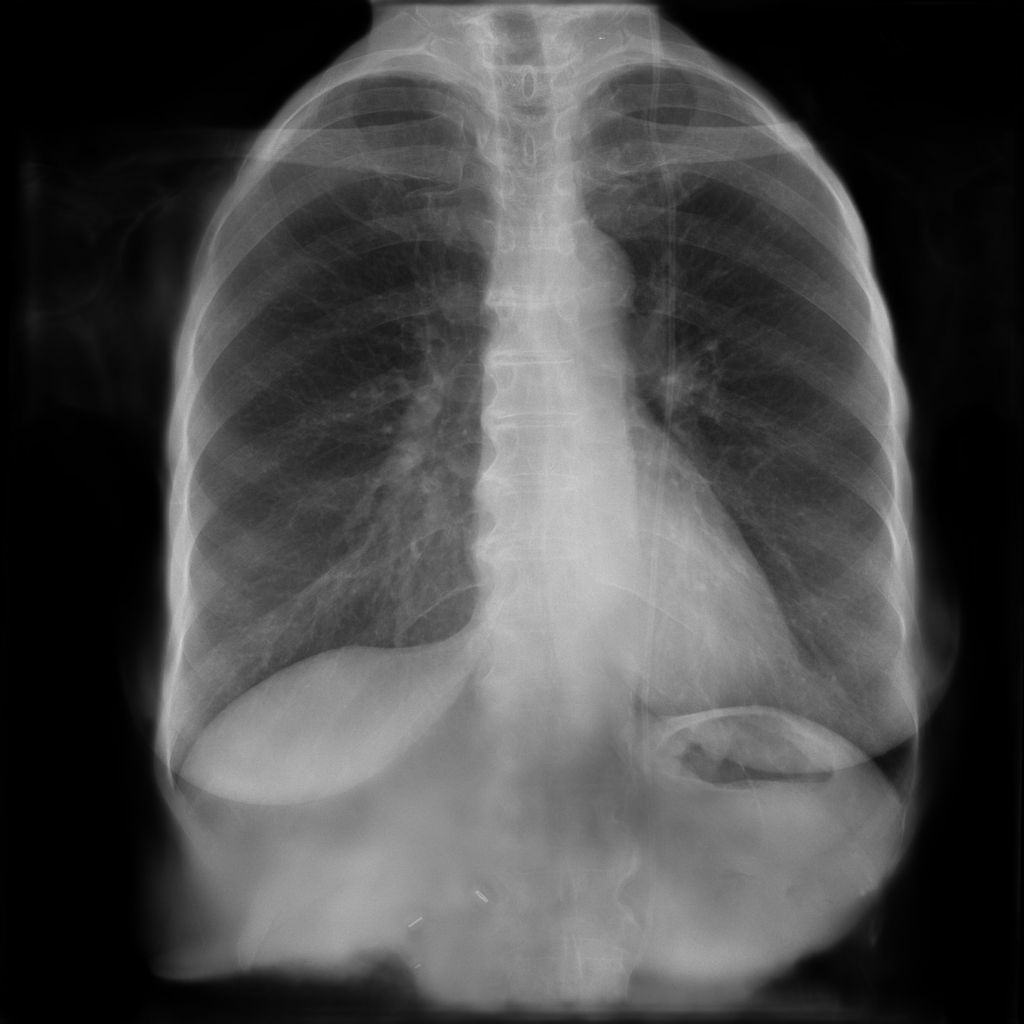

In [22]:
Image.fromarray(c)

In [1]:
import random
from time import time

# Main API Library
from PIL import Image, ImageFile, ImageOps
import time
import numpy as np
import tensorflow as tf
import scipy as sc

# Main Config From model
import base64
import os
from src.RestructModelings.config import get_cfg
import cv2
from src.RestructModelings import model_zoo
from src.RestructModelings.engine import DefaultPredictor
from src.RestructModelings.config import get_cfg
from src.RestructModelings.utils.visualizer import Visualizer, ColorMode
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import skimage.io as io
from src.RestructModelings.data import MetadataCatalog, DatasetCatalog
from PIL import ImageFile


/home/ai_car/anaconda3/envs/Python3.7/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'))
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGES = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
cfg.OUT_DIR = f'{os.getcwd()}/models/output/'
cfg.MODEL.WEIGHTS = ('/home/ai_car/Preprocessing-MedicalImage/results/v9/model_final.pth')
cfg['MODEL']['DEVICE'] = 'cuda:0'
predictor = DefaultPredictor(cfg)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


In [14]:
b = np.array(ImageOps.grayscale(Image.open('/home/ai_car/Preprocessing-MedicalImage/result/1221.png').convert('L')))
b = b.reshape(1024,1024)
# b.setflags(write=1)

/home/ai_car/anaconda3/envs/Python3.7/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


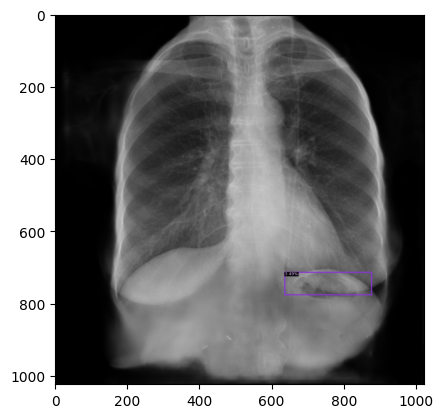

In [3]:
import matplotlib.pyplot as plt
c = cv2.imread('/home/ai_car/Preprocessing-MedicalImage/result/1221.png')
# c = Image.open('/home/ai_car/Preprocessing-MedicalImage/result/1221.png')
# c = c.reshape(1,c.shape[0],c.shape[1])
# c = Image.open('/home/ai_car/Preprocessing-MedicalImage/result/1221.png').convert('L')
# c = ImageOps.grayscale(c)
# c = np.asarray(c)
outputs = predictor(c)
v = Visualizer(c,
              # metadata=MetaData_PhysicalDamage,
              scale=1,
              instance_mode=ColorMode.SEGMENTATION
              )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
out = v.get_output()
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :])

In [4]:
c.shape[0]

1024

In [5]:
listtLocation = outputs['instances'].pred_boxes.tensor.cpu().numpy()
Problem = c[int(listtLocation[0][1]):int(listtLocation[0][3]), int(listtLocation[0][0]):int(listtLocation[0][2])]

In [6]:
m = tf.keras.models.load_model('/home/ai_car/Preprocessing-MedicalImage/model/brain_tumor.h5')
weights = m.layers[-1].get_weights()[0]
# get out of last convolution layer by name
new_model = tf.keras.models.Model(
    m.input, 
    m.get_layer('conv5_block16_concat').output
)


2023-01-12 22:56:28.073416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 22:56:28.074416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ai_car/anaconda3/envs/Python3.7/lib/python3.7/site-packages/cv2/../../lib64:
2023-01-12 22:56:28.074431: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-12 22:56:28.074629: I tensorflow/core/platform/cpu_feat

In [7]:
single_image = cv2.resize(Problem, (224, 224))
single_image = cv2.cvtColor(single_image, cv2.COLOR_BGR2RGB)
img = single_image/255
img = np.asarray(img)
img = img.reshape(1, 224, 224, 3)
y_pred = m.predict(img)[0]
y_pred = np.argmax(y_pred)
classes = list({'COVID': 0, 'Viral Pneumonia': 1})
class_prediction = classes[y_pred]
weights = m.layers[-1].get_weights()[0]
weights = np.asarray(weights)
weights = weights.reshape(weights.shape[1], weights.shape[0])
weights_for_predicted_class_for_this_image = weights[y_pred]
new_model = tf.keras.models.Model(
m.input, 
m.get_layer('conv5_block16_concat').output
)
output_con_layer = new_model.predict(img)[0]
resize_image = sc.ndimage.zoom(output_con_layer, (int(224/output_con_layer.shape[0]), 
                                                int(224/output_con_layer.shape[1]), 1))
final_image = np.dot(
    resize_image.reshape(resize_image.shape[0]*resize_image.shape[1], resize_image.shape[2]),
    weights_for_predicted_class_for_this_image
).reshape(resize_image.shape[0], resize_image.shape[1])
img_ = img.reshape(224, 224, 3)
final_image = final_image/255

2023-01-12 22:56:36.186559: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


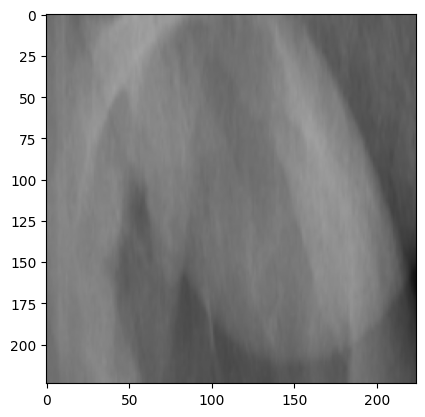

In [8]:
plt.imshow(img_)


In [20]:
final_image.shape

(62, 240)

In [ ]:
plt.imshow(final_image.resize(62,240))


In [11]:
copyfinal = final_image.copy()
copyfinal = np.resize(copyfinal,(62,240))

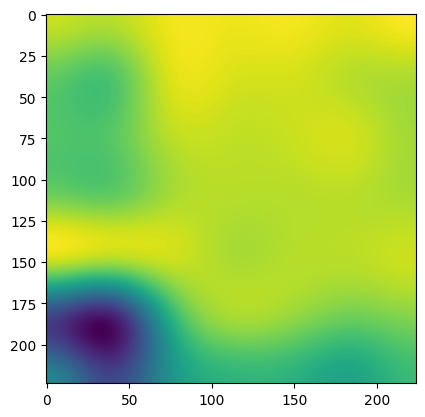

In [10]:
plt.imshow(final_image)

In [15]:
b

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [8, 8, 7, ..., 0, 0, 0],
       [8, 8, 7, ..., 0, 0, 0],
       [8, 8, 7, ..., 0, 0, 0]], dtype=uint8)

In [16]:
b[int(listtLocation[0][1]):int(listtLocation[0][3]), int(listtLocation[0][0]):int(listtLocation[0][2])] = copyfinal

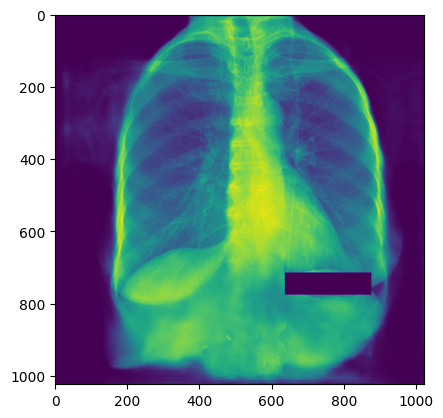

In [17]:
plt.imshow(b)